In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import statistics as stat
import statsmodels.api as sm

# Assignment 2

Due: 26th Sept, 11:59pm

# Problem 1: Spam, wonderful spam!

The dataset consists of a collection of 57 features relating to about 4600 emails and a label of whether or not the email is considered spam. You have a training set containing about 70% of the data and a test set containing about 30% of the data. Your job is to build effective spam classification rules using the predictors.

### A Note about Features

The column names (in the first row of each .csv file) are fairly self-explanatory.

* Some variables are named `word_freq_(word)`, which suggests a calculation of the frequency of how many times a specific word appears in the email, expressed as a percentage of total words in the email multiplied by 100.

* Some variables are named `char_freq_(number)`, which suggests a count of the frequency of the specific ensuing character, expressed as a percentage of total characters in the email multiplied by 100. Note, these characters are not valid column names in R, but you can view them in the raw .csv file. 

* Some variables are named `capital_run_length_(number)` which suggests some information about the average (or maximum length of, or total) consecutive capital letters in the email.

* `spam`: This is the response variable, 0 = not spam, 1 = spam.

### Missing Values

Unfortunately, the `capital_run_length_average` variable is corrupted and as a result, contains a fair number of missing values. These show up as `NaN` (the default way of representing missing values in Python.)

## Part a

Use $k$-nearest neighbors regression with $k=15$ to **impute** the missing values in the `capital_run_length_average` column using the other predictors after standardizing (i.e. rescaling) them. You may use a function such as <i>KNeighborsRegressor</i>  from the package <i>sklearn.neighbors</i> that performs $k$-nearest neighbors regression. There is no penalty for using a built-in function.

When you are done with this part, you should have no more NaN's in the `capital_run_length_average` column in either the training or the test set. To keep the training and test sets separate, you will need to build two models for imputing: one that is trained on, and imputes for, the training set, and another that is trained on, and imputes for, the test set. Make sure you show all of your work. (You may find the function <i>np.isnan()</i> useful for this problem.)

In [2]:
train = pd.read_csv("spam_train.csv")
test = pd.read_csv("spam_test.csv")

In [3]:
train = train.astype(float)
test = test.astype(float)

for i in [i for i in range(len(test.columns)) if i not in [54,57]]:
        test.iloc[:,i] = (test.iloc[:,i] - stat.mean(test.iloc[:,i]))/stat.stdev(test.iloc[:,i])
        train.iloc[:,i] = (train.iloc[:,i] - stat.mean(train.iloc[:,i]))/stat.stdev(train.iloc[:,i])

In [4]:
from sklearn.neighbors import KNeighborsRegressor as knr

neigh = knr(n_neighbors=15)
neigh.fit(train.drop("capital_run_length_average", axis=1)[-train["capital_run_length_average"].isnull()], np.asarray(train["capital_run_length_average"])[-train["capital_run_length_average"].isnull()].reshape(-1,1)) 

for i in [index for index, x in enumerate(train["capital_run_length_average"].isnull()) if x]:
    train["capital_run_length_average"][i] = float(neigh.predict(np.asarray(train.drop("capital_run_length_average", axis=1).iloc[i,]).reshape(1,-1)))

In [5]:
neigh = knr(n_neighbors=15)
neigh.fit(test.drop("capital_run_length_average", axis=1)[-test["capital_run_length_average"].isnull()], np.asarray(test["capital_run_length_average"])[-test["capital_run_length_average"].isnull()].reshape(-1,1)) 

for i in [index for index, x in enumerate(test["capital_run_length_average"].isnull()) if x]:
    test["capital_run_length_average"][i] = float(neigh.predict(np.asarray(test.drop("capital_run_length_average", axis=1).iloc[i,]).reshape(1,-1)))
    

In [6]:
test.iloc[:,54] = (test.iloc[:,54] - stat.mean(test.iloc[:,54]))/stat.stdev(test.iloc[:,54])
train.iloc[:,54] = (train.iloc[:,54] - stat.mean(train.iloc[:,54]))/stat.stdev(train.iloc[:,54])
ytrain = train["spam"]
train = train.drop("spam", axis=1)

In [7]:
imputedCapRun = test["capital_run_length_average"]

## Part b

Write a function named `knnclass()` that performs k-nearest neighbors classification, without resorting to a package. Essentially, we are asking you to recreate the <i>sklearn.neighbors.KNeighborsClassifier</i> function; though, we do not expect you to implement a fancy nearest neighbor search algorithm like what <i>KNeighborsClassifier</i> uses, just the naive search will suffice. Additionally, this function will be more sophisticated in the following way:

* The function should automatically do a split of the training data into a sub-training set (80%) and a validation set (20%) for selecting the optimal $k$.(More sophisticated cross-validation is not necessary.)

* The function should standardize each column: for a particular variable, say $x_1$, compute the mean and standard deviation of $x_1$ **using the training set only**, say $\bar x_1$ and $s_1$; then for each observed $x_1$ in the training set and test set, subtract $\bar x_1$, then divide by $s_1$.

_Note: You can assume that all columns will be numeric and that Euclidean distance is the distance measure._

The function skeleton is provided below.

In [8]:
import random
import math

def knnclass(xtrain, xtest, ytrain):
    
    print("standardize columns of all the dataframes")
    for i in range(len(xtest.columns)):
        mean = stat.mean(xtrain.iloc[:,i])
        stdev = stat.stdev(xtrain.iloc[:,i])
        xtest.iloc[:,i] = (xtest.iloc[:,i] - mean)/stdev
        xtrain.iloc[:,i] = (xtrain.iloc[:,i] - mean)/stdev
        
    #print (xtrain)
    #print (xtest)

    print("separate using 80-20 split")
    trainIndices = random.sample(range(len(xtrain)-1), round(0.8*(len(xtrain)-1)))
    testIndices = [item for item in range(len(xtrain)) if item not in trainIndices]    
    
    print("creating training and test sets for determining k")
    xtrainSet = xtrain.iloc[trainIndices,:]
    ytrainSet = [ytrain[i] for i in trainIndices] 
    xtestSet = xtrain.iloc[testIndices,:]
    ytestSet = [ytrain[i] for i in testIndices]
    
    print("generate Euclidean distances")
    testItemDistances = []
    for i in range(len(xtestSet)):
        indices = neighborIndices(xtrainSet, xtestSet.iloc[i,:])
        testItemDistances.append(indices)
        
    print("find MSE's of xtrainSet from ytrainSet, for values of k in kNN")
    accList = []
    for indexK in range(1,50):
        
        print("Now iterating on k: "+ str(indexK))
        #generate list of predictions for xtestSet using xtrainSet and ytrainSet        
        xtestSet_Predictions = []
        
        #for each test item, generate its prediction by going through training set and finding its majority
        for i in range(len(xtestSet)):
            
            indices = testItemDistances[i]
            indices = indices[:indexK]
            yPred = majority([ytrain[i] for i in indices])
            xtestSet_Predictions.append(yPred)
            #print ("majority set for " + str(indices) + " is given by " + str(list(ytrainSet.iloc[:,0][indices])) + " and the prediction is " + str(yPred))
            
        #find accuracy by comparing predictions to ytestSet and append to MSElist
        accList.append(1-metrics.accuracy_score(xtestSet_Predictions,ytestSet))
        
    k = accList.index(min(accList)) + 1
    print ("THE CHOSEN K IS " + str(k))

    print("generate Euclidean distances for actual test data")
    testItemDistancesFinal = []
    for i in range(len(xtest)):
        indices = neighborIndices(xtrainSet, xtest.iloc[i,:])
        testItemDistancesFinal.append(indices)

    #using correct k, generate list of predictions for xtestSet using xtrainSet and ytrainSet        
    finalPredictions = []
        
    print("using correct k, go through the training set and find the majority to serve as prediction")
    for i in range(len(xtest)):
        
        indices = testItemDistancesFinal[i]
        indices = indices[:k]
        yPred = majority([ytrain[i] for i in indices])
        finalPredictions.append(yPred)
    
    print("done")
    
    return (finalPredictions)

def neighborIndices(trainSet, testRow):
    #calculate its Euclidean distance from the other entries of TRAINING set
    distances = []
    for i in range(len(trainSet)):
        #print(trainSet.iloc[i,:])
        #print(list(testRow))
        #print(euclideanDist(list(trainSet.iloc[i,:]),list(testRow)))
        distances.append(euclideanDist(list(trainSet.iloc[i,:]),list(testRow)))
    indices = list(np.array(distances).argsort())
    return (trainSet.index[indices])
        
def euclideanDist(xRow, yRow):
    data = [a_i - b_i for a_i, b_i in zip(xRow, yRow)]
    return (np.linalg.norm(data))

from collections import Counter 
  
def majority(arr): 
    count0 = arr.count(0)
    count1 = arr.count(1)
    if count0 > count1:
        return (0)
    else:
        return (1)
    

## Part c

In this part, you will need to use a $k$-NN classifier to fit models on the actual dataset. If you weren't able to successfully write a $k$-NN classifier in Part b, you're permitted to use a built-in package for it. If you take this route, you may need to write some code to standardize the variables and select $k$, which `knnclass()` from part b already does. 

Now fit 4 models and produce 4 sets of predictions of `spam` on the test set:

1. `knnclass()` using all predictors except for `capital_run_length_average` (say, if we were distrustful of our imputation approach). Call these predictions `knn_pred1`.

2. `knnclass()` using all predictors including `capital_run_length_average` with the imputed values. Call these predictions `knn_pred2`.

3. logistic regression using all predictors except for `capital_run_length_average`. Call these predictions `logm_pred1`.

4. logistic regression using all predictors including `capital_run_length_average` with the imputed values. Call these predictions `logm_pred2`.

In 3-4 sentences, provide a quick summary of your second logistic regression model (model 4). Which predictors appeared to be most significant? Are there any surprises in the predictors that ended up being significant or not significant?

Submit a .csv file called `assn2_NETID_results.csv` that contains 5 columns:

* `capital_run_length_average`: the predictor in your test set that now contains the imputed values (so that we can check your work on imputation).

* `knn_pred1`

* `knn_pred2`

* `logm_pred1`

* `logm_pred2`

Make sure that row 1 here corresponds to row 1 of the test set, row 2 corresponds to row 2 of the test set, and so on.

In [ ]:
knn_pred1 = knnclass(train.drop(["capital_run_length_average"], axis=1), test.drop(["capital_run_length_average"], axis=1), ytrain)

In [ ]:
knn_pred2 = knnclass(train, test, ytrain)

In [11]:
from sklearn.linear_model import LogisticRegression
log1 = LogisticRegression(solver='lbfgs').fit(train.drop(["capital_run_length_average"], axis=1), ytrain)
logm_pred1 = log1.predict(test.drop(["capital_run_length_average"], axis=1))

In [12]:
checkData = log1.predict(train.drop(["capital_run_length_average"], axis=1))
sum(checkData == ytrain)/len(ytrain)

0.9251552795031056

In [13]:
log2 = LogisticRegression(solver='lbfgs').fit(train, ytrain)
logm_pred2 = log2.predict(test)
train.columns[abs(log2.coef_).argsort()[::-1]]

Index([['word_freq_1999', 'char_freq_(', 'word_freq_receive', 'word_freq_report', 'word_freq_people', 'word_freq_table', 'word_freq_make', 'word_freq_order', 'word_freq_will', 'word_freq_all', 'word_freq_email', 'word_freq_parts', 'word_freq_mail', 'word_freq_415', 'word_freq_labs', 'word_freq_you', 'char_freq_[', 'word_freq_650', 'word_freq_original', 'word_freq_over', 'word_freq_direct', 'word_freq_address', 'char_freq_!', 'word_freq_internet', 'word_freq_857', 'word_freq_addresses', 'word_freq_font', 'char_freq_;', 'capital_run_length_total', 'word_freq_technology', 'word_freq_your', 'word_freq_our', 'word_freq_business', 'word_freq_data', 'word_freq_money', 'word_freq_pm', 'word_freq_credit', 'word_freq_telnet', 'word_freq_85', 'char_freq_#', 'word_freq_3d', 'word_freq_free', 'word_freq_remove', 'word_freq_project', 'word_freq_re', 'word_freq_000', 'word_freq_hpl', 'word_freq_conference', 'char_freq_$', 'capital_run_length_average', 'word_freq_lab', 'word_freq_edu', 'word_freq_cs',

In [14]:
checkData = log2.predict(train)
print(sum(checkData == ytrain)/len(ytrain))

0.9251552795031056


In [83]:
import csv
csvData = {'capital_run_length_average': imputedCapRun, 
           'knn_pred1': knn_pred1,
           'knn_pred2': knn_pred2,
           'logm_pred1': logm_pred1, 
           'logm_pred2': logm_pred2}
csvData = pd.DataFrame(csvData)
csvData.to_csv('/Users/lorenzoflores/Desktop/Yale_Academic/S&DS 355/assn2_lyf6_results.csv')

The chosen k's for the first and second model were 8 and 3 respectively.

Based on the training data, the accuracy of the second logistic model was 92.52%. Because we standardized all the coefficients in the same way, we could base how significant each coefficient is based on its absolute value (method recommended by TA Adriel). From this, it came out to be that 'word_freq_1999', 'char_freq_(', and 'word_freq_receive' were the most significant coefficients. 

This wasn't surprising, because the model without the capital_run_length_average variable had the same accuracy as the model that did, implying that adding the variable did not improve training accuracy significantly, and therefore was probably not very significant to the model.

# Problem 2: Gradient Descent

Consider the scenario of univariate logistic regression where we are trying to predict $Y$, which can take the value $0$ or $1$, from the variable $X$, which can take the value of any real number. Recall from lecture that we need to predict parameters $\beta_{0}$ and $\beta_{1}$ by minimizing the penalized loss function:

$L(\beta_{0}, \beta_{1}) = \sum\limits_{i=1}^{n} \left[ log\left( 1 + e^{\beta_{0} + X_{i}\beta_{1}}\right) - Y_{i}\left(\beta_{0} + X_{i}\beta_{1}\right)\right] + \lambda\left(\beta_{0}^{2} + \beta_{1}^{2}\right)$ .

Run the next cell to simulate data from the true values of $\beta_{0} = 2.5$ and $\beta_{1} = 3.0$.

In [16]:
n = 10000 
x1 = np.random.uniform(-5, 5, size=n) 
beta0 = 2.5
beta1 = -3.0 
p = np.exp(beta0 + x1*beta1)/(1 + np.exp(beta0 + beta1*x1))
y = np.random.binomial(1, p, size=n)

## Part a

For given values of $\beta_{0}$ and $\beta_{1}$ the vector $\left( \dfrac{\partial}{\partial \beta_{0}} L(\beta_{0}, \beta_{1}), \dfrac{\partial}{\partial \beta_{1}} L(\beta_{0}, \beta_{1}) \right)^{T}$ is called the gradient of $L(\beta_{0}, \beta_{1})$ and is denoted $\nabla L(\beta_{0}, \beta_{1})$.

Calculate the derivative of $L(\beta_{0}, \beta_{1})$ with respect to $\beta_{0}$, treating $\beta_{1}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{0}} L(\beta_{0}, \beta_{1})$). 

Now calculate the derivative of $L(\beta_{0}, \beta_{1})$ with respect to $\beta_{1}$, treating $\beta_{0}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{1}} L(\beta_{0}, \beta_{1})$).

Be sure to show your work by either typing it in here using LaTeX, or by taking a picture of your handwritten solutions and displaying them here in the notebook. (If you choose the latter of these two options, be sure that the display is large enough and legible. You may find the example shown in the <i>Introduction to Python.ipynb</i> notebook for the Yale image useful.)

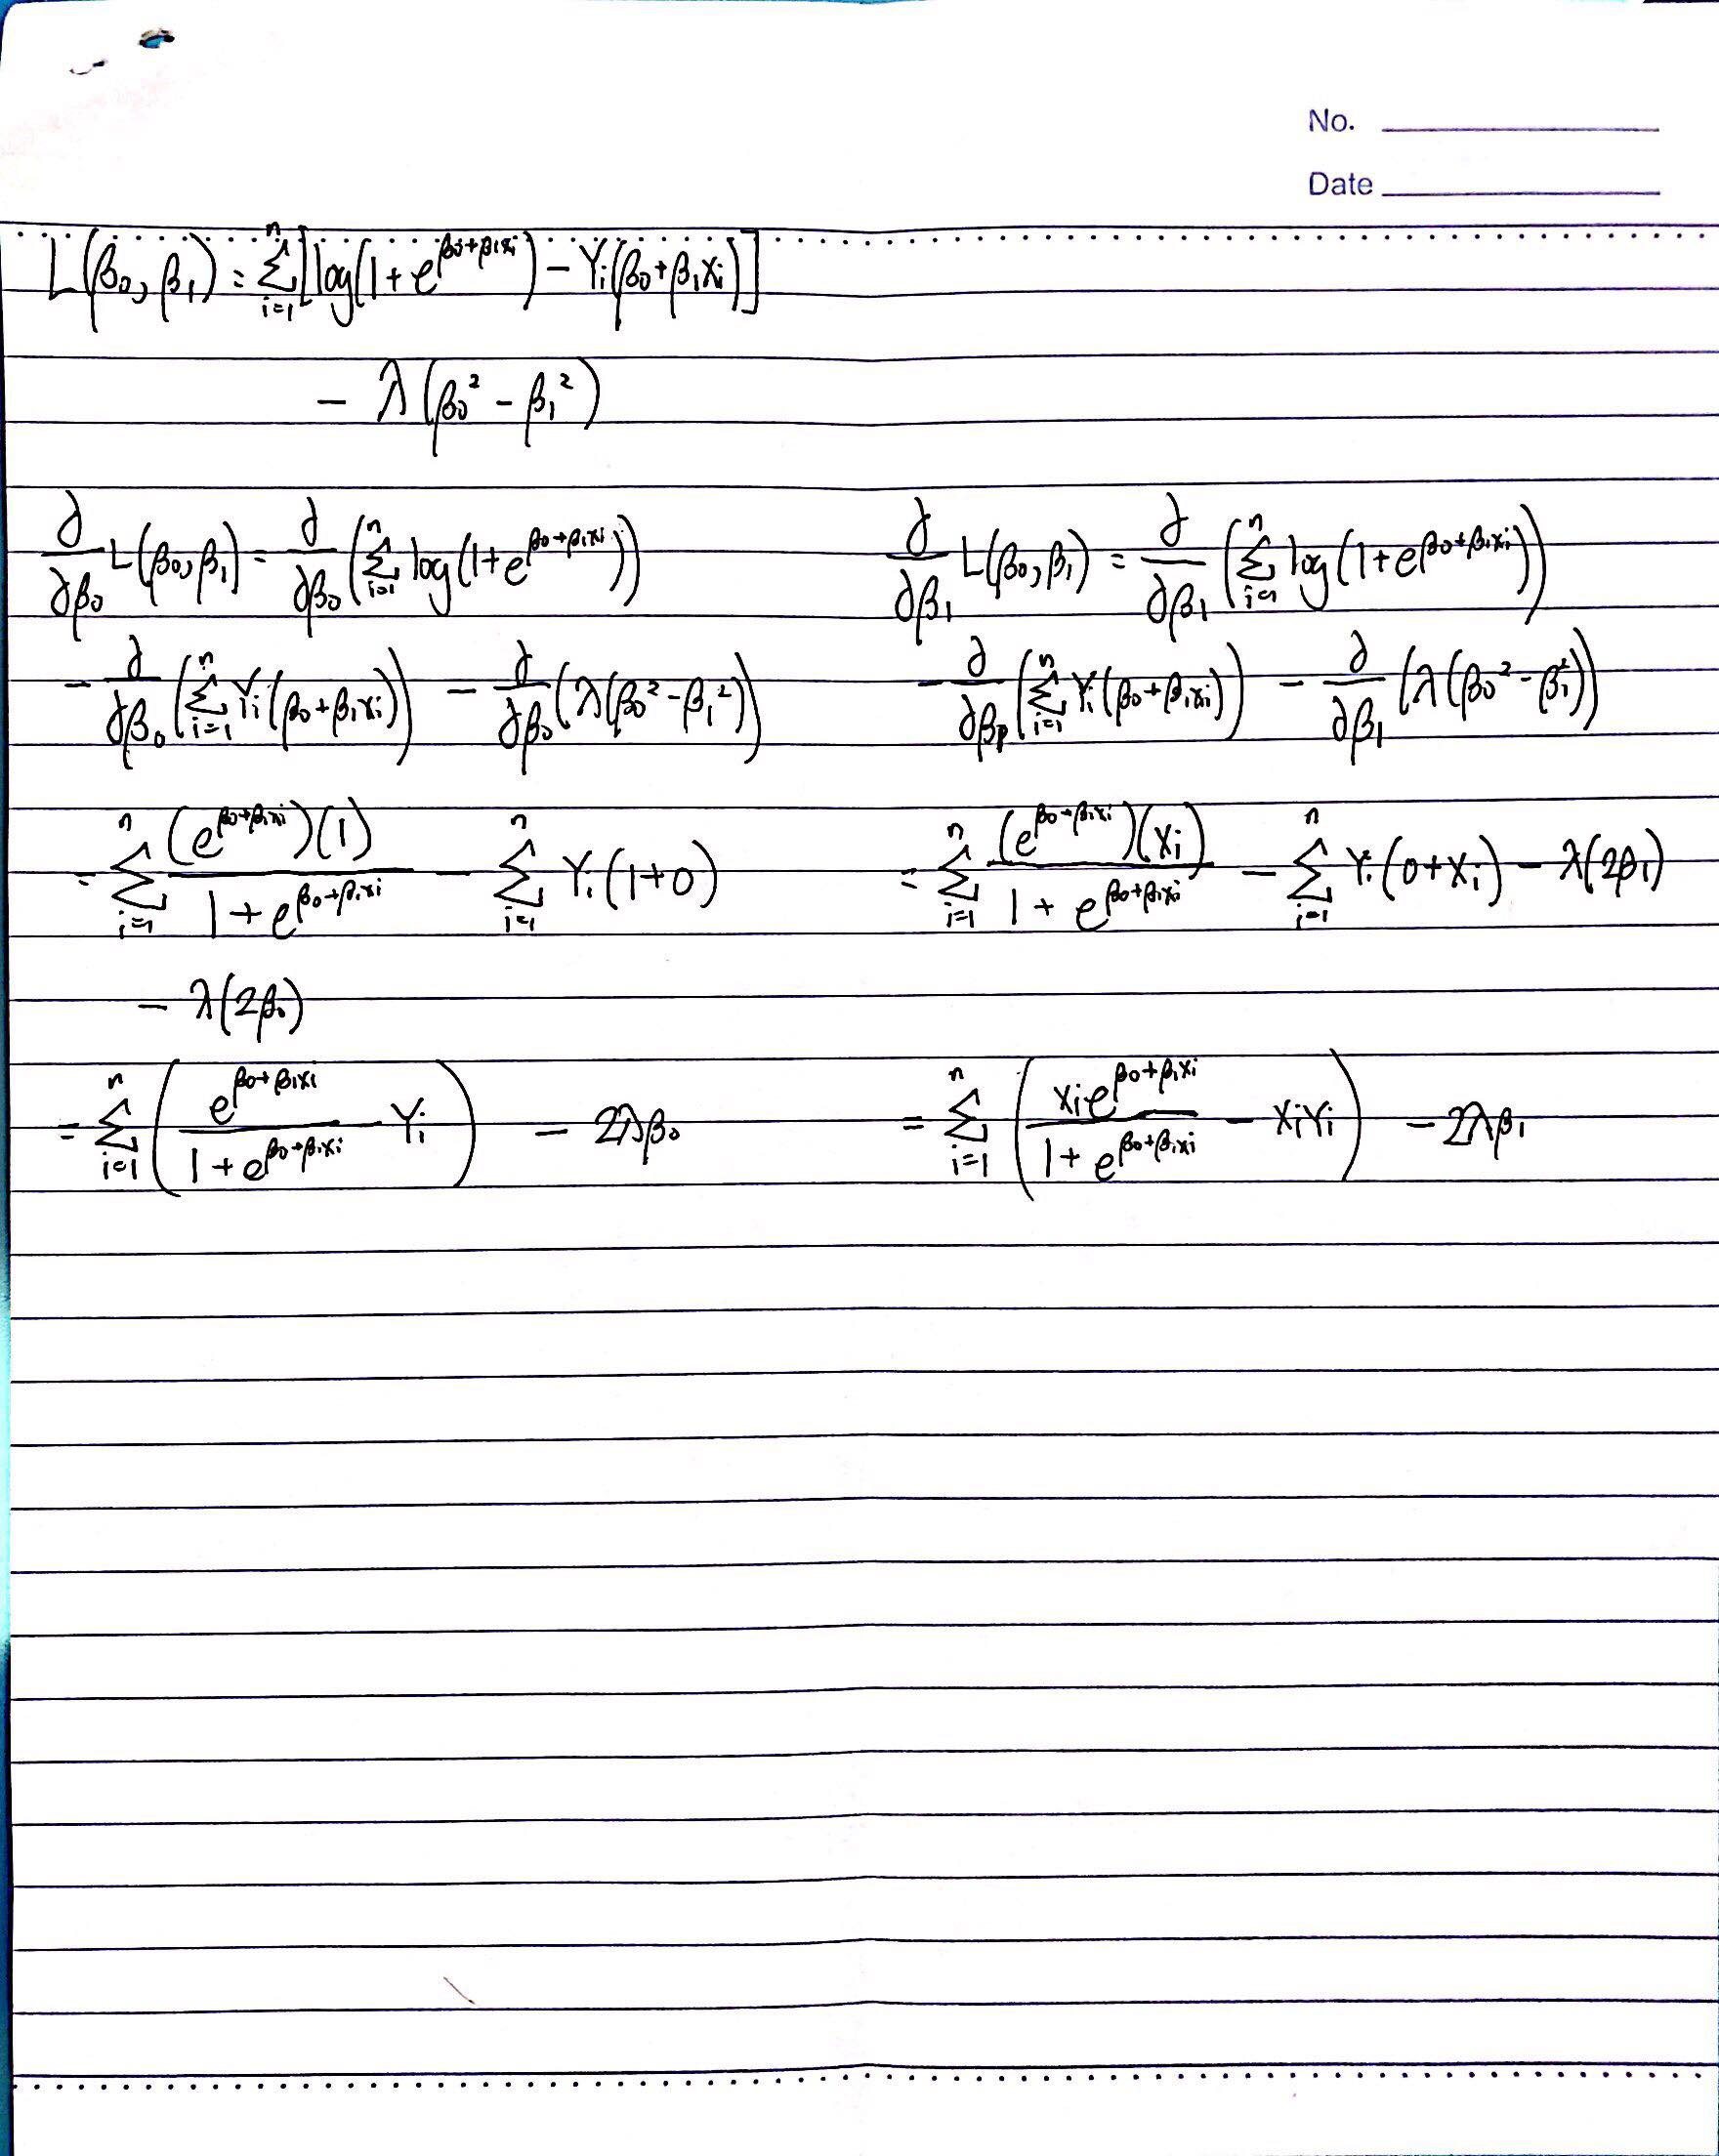

In [17]:
from IPython.display import Image
Image("/Users/lorenzoflores/Desktop/Yale_Academic/S&DS 355/HW2/lyf6 Loss Function Derivation.jpg")

## Part b

Complete the function in the following cell called <i>update()</i> which takes values for $\beta_{0}$ and $\beta_{1}$ as well as a step-size $\eta$ and should return updated values for $\beta_{0}$ and $\beta_{1}$ from one step of gradient descent (using all the data and your answer to Part a). You may use the value $0.01$ for $\lambda$.

In [18]:
import math 
def update(b0, b1, eta):
    
    derivb0 = 0.02*b0
    derivb1 = 0.02*b1
    
    for i in range(len(x1)):
        derivb0 += (np.exp(b0+b1*x1[i]))/(1+np.exp(b0+b1*x1[i])) - y[i]
        derivb1 += (x1[i]*(math.exp(b0+b1*x1[i])))/(1+math.exp(b0+b1*x1[i])) - (x1[i]*y[i])
    
    b0new = b0 - (eta*derivb0)
    b1new = b1 - (eta*derivb1)
    
    return ([b0new, b1new])

Now complete the function in the next cell called <i>loss()</i> which takes values for $\beta_{0}$ and $\beta_{1}$ and should return the value of the loss function evaluated at those two parameter values.

In [19]:
def loss(b0, b1):
    l = 0.01*((b0**2) + (b1**2))
    
    for i in range(len(x1)):
        l += math.log(1+math.exp(b0+(x1[i]*b1)))-(y[i]*(b0+(x1[i]*b1)))
        
    return (l)

## Part c

The following cell uses the two functions from Part b to implement gradient descent for this problem, keeping track of the values for $\beta_{0}$, $\beta_{1}$, and $L(\beta_{0}, \beta_{1})$ at each iteration. In the cell below the code, answer each of the questions included as comments next to the code. Also, create individual plots of $\beta_{0}$, $\beta_{1}$, and $L(\beta_{0}, \beta_{1})$ vs. iteration number. Do these three quantities behave as expected for gradient descent?

In [20]:
step = 0.01
beta0_hat = 0
beta1_hat = 0
l = loss(beta0_hat, beta1_hat)
beta0_all = [beta0_hat]
beta1_all = [beta1_hat]
loss_all = [l]
i=0
while i < 400 and step > 3e-8:              #1. What is the reasoning behind these two stopping criteria?
    b = update(beta0_hat, beta1_hat, step)  #2. What is being calculated here?
    l_new = loss(b[0], b[1])                #3. What is being calculated here?
    if l_new < l:                           #4. What happens if the statement being tested here is True?
        beta0_hat = b[0]
        beta1_hat = b[1]
        l = l_new
    else:
        step = step*0.9                     #5. What happens if the statement tested above is False? What is the reasoning
                                            #   behind this?
    i = i+1
    beta0_all.append(beta0_hat)
    beta1_all.append(beta1_hat)
    loss_all.append(l)

1. In order to prevent the program from running forever, we cap the program in terms of its iterations and the closeness of the slope to the real value. A maximum of 400 iterations is implemented to cap gradient descent, which most likely gives the function ample time to reach satisfactory estimates for the coefficients. Also, if the slope is found to be extremely close to its real value (i.e. step =< 3e-8), then the program will stop.

2. The update function returns a list with the updated values of the slope and intercept for the logistic regression, which are obtained by moving away from the old intercept, by a distance of the product of the loss function's slope and learning rate, to the new intercept estimates.

3. The loss function calculates the "error" between the data and what a model would predict using the coefficients b0 and b1, as defined by the penalized loss function L defined above.

4. When updating the coefficients decreases the loss, this means the function is getting better at predicting the model, and so we update the model's coefficients to the new b0 and b1.

5. When updating the coefficients increases the loss, this means we have overshot the minimal value of loss - implying that we took a step too big and missed our target value. Thus, we minimize the step size (learning rate) and try estimating again.


Text(0, 0.5, 'b0')

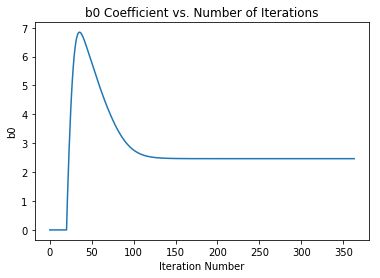

In [21]:
plt.plot(beta0_all)
plt.title('b0 Coefficient vs. Number of Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('b0')

Text(0, 0.5, 'b1')

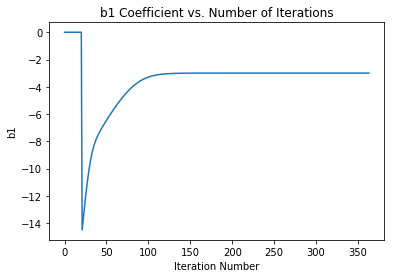

In [22]:
plt.plot(beta1_all)
plt.title('b1 Coefficient vs. Number of Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('b1')

Text(0, 0.5, 'Loss')

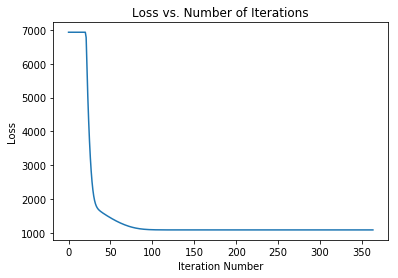

In [23]:
plt.plot(loss_all)
plt.title('Loss vs. Number of Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')

The estimates plateau out to values around 2.5 and -3 respectively, which follow the expected behavior where the coefficient slowly approaches the correct value as more iterations are produced. Furthermore, it does reach our initial coefficients of 2.5 and -3 which is what we desired. The error function also decreases through iterations as expected since we supposedly get closer and closer to a model that fits the data better, thereby producing less error.

## Part d

Is your gradient descent algorithm from Part b robust against initial estimates of $\beta_{0}$ and $\beta_{1}$? To help answer this question, take the code above that implements gradient descent and put it in a function that takes initial estimates of $\beta_{0}$ and $\beta_{1}$ as arguments, and returns the optimized values from gradient descent. Run this function using each of the following pairs of $(\beta_{0}, \beta_{1})$ as initial estimates: $(15, 3)$, $(-30, 5)$, and $(-8, -8)$. Are your final estimates approximately the same each time?

In [24]:
def gradDescent(beta0, beta1, step):
    
    step = step
    beta0_hat = beta0
    beta1_hat = beta1
    
    l = loss(beta0_hat, beta1_hat)
    
    beta0_all = [beta0_hat]
    beta1_all = [beta1_hat]
    loss_all = [l]
    
    i=0
    while i < 400 and step > 3e-8:            
        b = update(beta0_hat, beta1_hat, step)  
        l_new = loss(b[0], b[1])                
        if l_new < l:                           
            beta0_hat = b[0]
            beta1_hat = b[1]
            l = l_new
        else:
            step = step*0.9                     
            
        i = i+1
    
        beta0_all.append(beta0_hat)
        beta1_all.append(beta1_hat)
        loss_all.append(l)
        
    return ([beta0_hat, beta1_hat])

In [25]:
print(gradDescent(15,3,0.01))
print(gradDescent(-30,5,0.01))
print(gradDescent(-8,-8,0.01))

[2.466018811762613, -2.993646620792152]
[2.466018812223975, -2.9936466203188288]
[2.466018814317139, -2.9936466181725994]


Yes, the final approximates are relatively the same, and all reach the values of 2.46 and -2.99, which are quite close to the correct values of 2.5 and -3.0.

This makes sense because of the large number of iterations condition which allows gradient descent to reach a similar answer regardless of initial estimates. Therefore, we can say it is robust against initial estimates of beta 0 and 1.

# Problem 3: Cross-Validation

## Part a

Generate a simulated data set with the following cell:

In [71]:
np.random.seed(1)
x = np.random.normal(size=100)
y = x - 2*x**2 + np.random.normal(size=100)

In this data set, what is the value of $n$ (the number of data points) and what is the value of $p$ (the true number of model parameters)? Write out the model used to generate the data in equation form.

$$ n = 100, p = 2 $$
The x's are generated by randomly generating numbers from the normal distribution

Whereas the y's are generated by $ y_i = x_i - 2{x_i}^2 + \varepsilon $ where $ \varepsilon $ is a random noise term also genenerated randomly from the normal distribution


## Part b

Create a scatterplot of $X$ against $Y$. Comment on what you find.

Text(0, 0.5, 'y')

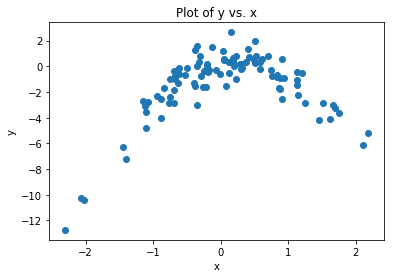

In [72]:
plt.scatter(x,y)
plt.title('Plot of y vs. x')
plt.xlabel('x')
plt.ylabel('y')

The resulting data follows a quadratic pattern with some noise, which approximates a curve that is concave down and has a vertex approximately at (0,0)

## Part c

Set a random seed, and then compute the Leave-One-Out Cross-Validation (LOOCV) errors that result from fitting the following four models using least squares:
         
i. $Y = \beta_0 + \beta_1 X + \epsilon$

ii. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon$

iii. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$ 

iv. $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \epsilon$ 

Note: for linear regression, the LOOCV error can be computed via the following short-cut formula:

$$  \text{LOOCV Error} = \frac{1}{n}\sum_{i=1}^{n} \bigg( \frac{Y_i - \widehat{Y_i}}{1-H_{ii}} \bigg)^2$$

where $H_{ii}$ is the $i^\text{th}$ diagonal entry of the projection matrix $H = \textbf{X}(\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T$, and $\textbf{X}$ is a matrix of predictors (the design matrix). This formula is an alternative to actually carrying out the $n = 100$ regressions you would otherwise need for LOOCV. An example of how to calculate the projection matrix $H$ is provided below for the case of $n=5$ and the model $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon$ . To get the diagonal elements of $H$ you may find the function `np.diag()` useful.

In [73]:
example_x = np.array([-3, -4, -5, -6, -7])        #generate the x variable
design_x = np.vander(example_x, 3)          #calculate the design matrix for the polynomial model with 3 fit parameters
H = np.dot(design_x, np.dot(np.linalg.inv(np.dot(design_x.T, design_x)), design_x.T))  #calculate H

In [74]:
x2 = [item**2 for item in x]
x3 = [item**3 for item in x]
x4 = [item**4 for item in x]
xData = pd.DataFrame(
    {'x1': x,
     'x2': x2,
     'x3': x3,
     'x4': x4
    })
xData = sm.add_constant(xData)

In [75]:
import statsmodels.api as sm

lm1 = sm.OLS(y, xData.iloc[:,[0,1]])
lm1mod = lm1.fit()
lm1pred = lm1mod.predict(xData.iloc[:,[0,1]])

lm2 = sm.OLS(y, xData.iloc[:,[0,1,2]])
lm2mod = lm2.fit()
lm2pred = lm2mod.predict(xData.iloc[:,[0,1,2]])

lm3 = sm.OLS(y, xData.iloc[:,[0,1,2,3]])
lm3mod = lm3.fit()
lm3pred = lm3mod.predict(xData.iloc[:,[0,1,2,3]])

lm4 = sm.OLS(y, xData.iloc[:,[0,1,2,3,4]])
lm4mod = lm4.fit()
lm4pred = lm4mod.predict(xData.iloc[:,[0,1,2,3,4]])

In [76]:
def LOOCV(original, predicted, data, power):

    example_x = np.array(data)        
    design_x = np.vander(example_x, power+1)
    H = np.dot(design_x, np.dot(np.linalg.inv(np.dot(design_x.T, design_x)), design_x.T))
    
    Hvals = np.diag(H)
    
    errorSum = 0
    for i in range(len(original)):
        errorSum += ((original[i]-predicted[i])/(1-Hvals[i]))**2
    
    errorSum /= len(original)
    
    return (errorSum)

In [77]:
print("Using b0 and b1: " + str(LOOCV(y, lm1pred, x, 1)))
print("Using b0, b1 and b2: " + str(LOOCV(y, lm2pred, x, 2)))
print("Using b0, b1, b2, and b3: " + str(LOOCV(y, lm3pred, x, 3)))
print("Using b0, b1, b2, b3, and b4: " + str(LOOCV(y, lm4pred, x, 4)))

Using b0 and b1: 6.260764331604616
Using b0, b1 and b2: 0.9142897072803661
Using b0, b1, b2, and b3: 0.9268768781648802
Using b0, b1, b2, b3, and b4: 0.8669116865881079


As shown by the LOOCV error, a quartic model is able to come up with the smallest error. This is interesting because we used a quadratic model to generate the data.

## Part d

Repeat Part c using another random seed to generate data, and report your results. Are your results the same as what you got in Part c? Why?

In [78]:
np.random.seed(29)

x = np.random.normal(size=100)
y = x - 2*x**2 + np.random.normal(size=100)
x2 = [item**2 for item in x]
x3 = [item**3 for item in x]
x4 = [item**4 for item in x]
xData = pd.DataFrame(
    {'x1': x,
     'x2': x2,
     'x3': x3,
     'x4': x4
    })
xData = sm.add_constant(xData)

lm1a = sm.OLS(y, xData.iloc[:,[0,1]])
lm1amod = lm1a.fit()
lm1apred = lm1amod.predict(xData.iloc[:,[0,1]])

lm2a = sm.OLS(y, xData.iloc[:,[0,1,2]])
lm2amod = lm2a.fit()
lm2apred = lm2amod.predict(xData.iloc[:,[0,1,2]])

lm3a = sm.OLS(y, xData.iloc[:,[0,1,2,3]])
lm3amod = lm3a.fit()
lm3apred = lm3amod.predict(xData.iloc[:,[0,1,2,3]])

lm4a = sm.OLS(y, xData.iloc[:,[0,1,2,3,4]])
lm4amod = lm4a.fit()
lm4apred = lm4amod.predict(xData.iloc[:,[0,1,2,3,4]])

print("Using b0 and b1: " + str(LOOCV(y, lm1apred, x, 1)))
print("Using b0, b1 and b2: " + str(LOOCV(y, lm2apred, x, 2)))
print("Using b0, b1, b2, and b3: " + str(LOOCV(y, lm3apred, x, 3)))
print("Using b0, b1, b2, b3, and b4: " + str(LOOCV(y, lm4apred, x, 4)))

Using b0 and b1: 17.93775926207543
Using b0, b1 and b2: 0.7741500721343136
Using b0, b1, b2, and b3: 0.7780912364021855
Using b0, b1, b2, b3, and b4: 0.7701611460270601


In terms of the error, the results are not the same, and this is expected because setting a different seed will generate a different set of data, which may be more or less noisy due to the random noise term introduced in y. As a result, the errors that result from the linear, quadratic, cubic and quartic functions will be different from seed to seed. 

However, like the previous model, it is still the quartic model still exhibits the lowest error. In fact, we still see the same trend where the linear model has a high error, while the quadratic, cubic, and quartic models have relatively low errors, which we expect since these functions can better simulate curves whereas linear models cannot.

## Part e

Which of the models in Part c had the smallest LOOCV error? Is this what you expected? Explain your answer.

In parts c and d, it was the quartic function that displayed the smallest LOOCV error. This was unexpected since we used a quadratic term to generate our data, and so I was expecting the quadratic model to exhibit the lowest error. 

However, it is understandable that the quartic function produced the lowest error, since unlike a quadratic which can have a maximum of one turning point, a quartic function can have 3, which allows it to better capture the noise in the data that leads to its lower error.

## Part f

Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in Part c using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

In [79]:
lm1mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.997
Date:                Thu, 26 Sep 2019   Prob (F-statistic):            0.00209
Time:                        22:18:33   Log-Likelihood:                -228.87
No. Observations:                 100   AIC:                             461.7
Df Residuals:                      98   BIC:                             466.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4131      0.242     -5.849      0.000      -1.893      -0.934
x1             0.8610      0.272      3.162      0.002       0.321       1.401
==============================================================================
Omnibus:                       37.310   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.521
Skew:                          -1.554   Prob(JB):                     8.01e-16
Kurtosis:                       5.651   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
lm2mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     304.9
Date:                Thu, 26 Sep 2019   Prob (F-statistic):           1.47e-42
Time:                        22:18:37   Log-Likelihood:                -134.42
No. Observations:                 100   AIC:                             274.8
Df Residuals:                      97   BIC:                             282.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1350      0.115      1.169      0.245      -0.094       0.364
x1             1.0936      0.107     10.229      0.000       0.881       1.306
x2            -1.9846      0.085    -23.331      0.000      -2.153      -1.816
==============================================================================
Omnibus:                        0.893   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.552
Skew:                          -0.170   Prob(JB):                        0.759
Kurtosis:                       3.132   Cond. No.                         2.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
lm3mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     204.8
Date:                Thu, 26 Sep 2019   Prob (F-statistic):           1.40e-41
Time:                        22:18:40   Log-Likelihood:                -133.66
No. Observations:                 100   AIC:                             275.3
Df Residuals:                      96   BIC:                             285.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1280      0.115      1.111      0.269      -0.101       0.357
x1             0.9065      0.187      4.842      0.000       0.535       1.278
x2            -1.9753      0.085    -23.187      0.000      -2.144      -1.806
x3             0.0788      0.065      1.216      0.227      -0.050       0.208
==============================================================================
Omnibus:                        1.539   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.081
Skew:                          -0.236   Prob(JB):                        0.583
Kurtosis:                       3.193   Cond. No.                         5.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
lm4mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     163.0
Date:                Thu, 26 Sep 2019   Prob (F-statistic):           1.24e-41
Time:                        22:18:42   Log-Likelihood:                -130.63
No. Observations:                 100   AIC:                             271.3
Df Residuals:                      95   BIC:                             284.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3140      0.136      2.311      0.023       0.044       0.584
x1             0.9127      0.183      4.999      0.000       0.550       1.275
x2            -2.5445      0.248    -10.264      0.000      -3.037      -2.052
x3             0.0992      0.064      1.556      0.123      -0.027       0.226
x4             0.1394      0.057      2.437      0.017       0.026       0.253
==============================================================================
Omnibus:                        1.537   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.088
Skew:                          -0.238   Prob(JB):                        0.581
Kurtosis:                       3.184   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that models containing more significant terms and fewer non-significant terms (at alpha = 0.05) had lower LOOCVs (e.g. quartic and quadratic), whereas models with few significant terms or more non-significant terms had higher LOOCVs (e.g. linear and cubic). This agrees with the results from part c.

On the three models with the quadratic term, its coefficient was always statistically significant at a level of 0.05. This makes sense that it captured most of the variability in the data, since our model was based on a quadratic form. 